In [1]:
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from aerobot.io import load_training_data, load_validation_data
from aerobot.utls import process_data, count_aa_kmers, download_genomes_from_assembly
from aerobot.models import LogisticClassifier

from collections import defaultdict
from matplotlib import pyplot as plt
from os import path
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import viz
colors = viz.plotting_style()
default_pal = [
    colors['purple'], colors['dark_green'], colors['light_blue'], 
    colors['red'], colors['dark_green'], colors['dark_brown'],
    colors['yellow'], colors['light_red'], colors['light_blue'], 
    colors['light_green'], colors['light_purple']]

plt.style.use('style.mpl')

In [2]:
colors

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426',
 'dark_blue': '#535D87'}

In [3]:
# Load training dataset and validation dataset
feature_type = "metadata"
training_data = load_training_data(feature_type=feature_type)
validation_data = load_validation_data(feature_type=feature_type)

training_phyla_counts = training_data['labels'].gtdb_taxonomy.str.split(';', expand=True)[1].str.strip('p__').value_counts()
validation_phyla_counts = validation_data["labels"].Phylum.value_counts()

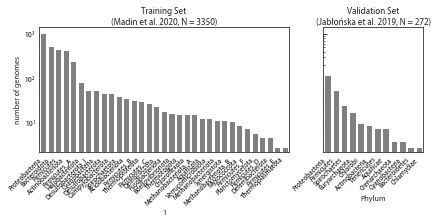

In [4]:
# Fig S1: composition of training and test sets.
fig, axs = plt.subplots(figsize=(6.875, 2.3), ncols=2, sharey=True, gridspec_kw={'width_ratios': [2.5, 1]})

plt.sca(axs[0])
plt.yscale('log')
mask = training_phyla_counts > 2
masked = training_phyla_counts[mask]
sns.barplot(x=masked.index, y=masked.values, color='grey')
plt.xticks(rotation=45, ha='right')
plt.ylabel('number of genomes')
plt.title('Training Set\n(Madin et al. 2020, N = {0})'.format(training_phyla_counts.sum()))

plt.sca(axs[1])
plt.yscale('log')
mask = validation_phyla_counts > 2
masked = validation_phyla_counts[mask]
sns.barplot(x=masked.index, y=masked.values, color='grey')
plt.xticks(rotation=45, ha='right')
plt.title('Validation Set\n(Jabłońska et al. 2019, N = {0})'.format(validation_phyla_counts.sum()))

plt.savefig('../../results/FigS1.png', dpi=300, bbox_inches='tight', facecolor='w')  
plt.show()

In [5]:
# Load model results
results_dir = '../../results/'
logit_res_path = path.join(results_dir, 'logisticReg_l2_c100_models.noNorm.04Oct2023.pkl')
model_results_df = pd.read_pickle(logit_res_path)

In [6]:
model_results_df.head()

,feature_set,accuracy,balanced_accuracy,test_accuracy,test_balanced_accuracy,model
0,Number of genes,0.618096,0.466482,0.503676,0.440509,<aerobot.models.GeneralClassifier object at 0x...
1,Number of O2 genes,0.782902,0.603371,0.665441,0.576282,<aerobot.models.GeneralClassifier object at 0x...
2,Percent O2 genes,0.802291,0.615534,0.694853,0.614096,<aerobot.models.GeneralClassifier object at 0x...
3,5 gene set genes,0.733918,0.572618,0.676471,0.584547,<aerobot.models.GeneralClassifier object at 0x...
4,Terminal oxidase genes,0.793275,0.608565,0.617647,0.550177,<aerobot.models.GeneralClassifier object at 0x...


In [7]:

model_results_df['balanced_accuracy_pct'] = model_results_df['balanced_accuracy']*100
model_results_df['test_balanced_accuracy_pct'] = model_results_df['test_balanced_accuracy']*100

model_results_long_df = model_results_df.melt(
    id_vars='feature_set', 
    value_vars=['balanced_accuracy_pct', 'test_balanced_accuracy_pct'],
    value_name='_tmp', var_name='evaluation').sort_values('_tmp')
model_results_long_df.rename(columns={'_tmp': 'balanced_accuracy_pct'}, inplace=True)
model_results_long_df['eval_name'] = model_results_long_df['evaluation'].map({
    'balanced_accuracy_pct': 'training',
    'test_balanced_accuracy_pct': 'validation'
})

feature_name_map = {
    'Nucleotide kmer counts (1 mer)': 'DNA 1-mer',
    'Nucleotide kmer counts (2 mer)': 'DNA 2-mer',
    'Nucleotide kmer counts (3 mer)': 'DNA 3-mer',
    'Nucleotide kmer counts (4 mer)': 'DNA 4-mer',
    'Nucleotide kmer counts (5 mer)': 'DNA 5-mer',
    'Amino acid counts (1 mer)': 'Amino acid 1-mer',
    'Amino acid counts (2 mer)': 'Amino acid 2-mer',
    'Amino acid counts (3 mer)': 'Amino acid 3-mer',
    'Number of genes': 'Gene count',
    'Number of O2 genes': 'O$_2$ gene count',
    'Percent O2 genes': 'O$_2$ gene fraction',
    'All O2 genes': 'O$_2$ utilizing enzymes',
    'Terminal oxidase genes': 'Terminal oxidases',
    '5 gene set genes': '5 gene set',
    'All KO families': 'All gene families',
    'genome embedding': 'Genome embedding',
    'Chemical features': 'Chemical features', }
model_results_long_df['feature_name'] = model_results_long_df['feature_set'].map(
    feature_name_map)

# Mark the annotation-free models
model_results_long_df['annotation_free'] = True
mask = model_results_long_df['feature_set'].str.contains('gene')
model_results_long_df.loc[mask, 'annotation_free'] = False
mask = model_results_long_df['feature_set'].str.contains('families')
model_results_long_df.loc[mask, 'annotation_free'] = False
mask = model_results_long_df['feature_set'] == 'Number of genes'
model_results_long_df.loc[mask, 'annotation_free'] = True

model_results_long_df.head()

,feature_set,evaluation,balanced_accuracy_pct,eval_name,feature_name,annotation_free
28,Nucleotide kmer counts (1 mer),test_balanced_accuracy_pct,34.821146,validation,DNA 1-mer,True
11,Nucleotide kmer counts (1 mer),balanced_accuracy_pct,38.669705,training,DNA 1-mer,True
29,Nucleotide kmer counts (2 mer),test_balanced_accuracy_pct,42.101931,validation,DNA 2-mer,True
33,Chemical features,test_balanced_accuracy_pct,43.886205,validation,Chemical features,True
17,Number of genes,test_balanced_accuracy_pct,44.050899,validation,Gene count,True


In [8]:
cols = ['feature_set', 'balanced_accuracy', 'test_balanced_accuracy']
model_results_df[cols].sort_values('test_balanced_accuracy', ascending=False)

,feature_set,balanced_accuracy,test_balanced_accuracy
6,All KO families,0.978323,0.740200
7,genome embedding,0.737981,0.707161
10,Amino acid counts (3 mer),0.828683,0.704285
15,Nucleotide kmer counts (5 mer),0.749074,0.670408
5,All O2 genes,0.773037,0.655042
9,Amino acid counts (2 mer),0.739725,0.648486
2,Percent O2 genes,0.615534,0.614096
14,Nucleotide kmer counts (4 mer),0.673315,0.603413
3,5 gene set genes,0.572618,0.584547
1,Number of O2 genes,0.603371,0.576282


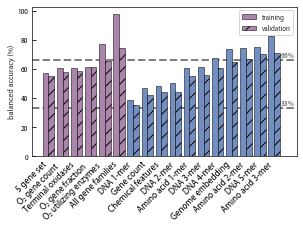

In [9]:
plt.figure(figsize=(4.75, 2.75))

tmp = model_results_long_df.copy().set_index('feature_set').sort_values('annotation_free,balanced_accuracy_pct'.split(','))

mask = tmp['eval_name'] == 'training'
bar_heights_train = tmp[mask].balanced_accuracy_pct
mask = tmp['eval_name'] == 'validation'
bar_heights_valid = tmp[mask].balanced_accuracy_pct

# convert annotation_free to a dictionary 
is_annot_free = tmp['annotation_free'].to_dict()

cmap = {'annot_free': colors['blue'], 'annot_full': colors['purple']}

order = [feature_name_map[x] for x in bar_heights_train.index]
color_order = [colors['blue'] if is_annot_free[x] else colors['purple'] for x in bar_heights_train.index]
n = bar_heights_train.size
xs = np.arange(n)
plt.bar(xs, bar_heights_train, color=color_order, width=0.4, label='training',
        edgecolor='k', linewidth=0.5)
plt.bar(xs+0.4, bar_heights_valid, color=color_order, hatch='//', width=0.4, label='validation',
        edgecolor='k', linewidth=0.5)
plt.xticks(xs+0.2, order, rotation=45, ha='right', fontsize=9)

plt.axhline(33, ls='--', color='grey', zorder=-1)
plt.text(16.7, 34.5, '33%', color='grey', fontsize=7, fontweight='bold')
plt.axhline(66, ls='--', color='grey', zorder=-1)
plt.text(16.7, 67.5, '66%', color='grey', fontsize=7, fontweight='bold')
plt.xlim(-1, 17.8)

plt.legend(title='', fontsize=7)
plt.ylabel('balanced accuracy (%)')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel('')
plt.savefig('../../results/FigS2.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


All KO families KO
Amino acid counts (3 mer) aa_3mer
Nucleotide kmer counts (5 mer) nt_5mer


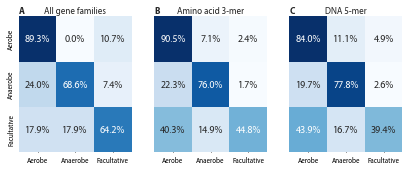

In [10]:
top_models = 'All KO families,Amino acid counts (3 mer),Nucleotide kmer counts (5 mer)'.split(',')
feature_set_names = 'KO,aa_3mer,nt_5mer'.split(',')

fig, axs = plt.subplots(ncols=3, figsize=(6.875, 2.5), sharey=True)

for i, (model_name, feature_set) in enumerate(zip(top_models, feature_set_names)):
    print(model_name, feature_set)
    # Get the validation data to calculate the confusion matrix
    training_data = load_training_data(feature_type=feature_set)
    validation_data = load_validation_data(feature_type=feature_set)
    cleaned_data = process_data(training_data["features"],
                                training_data["labels"]["physiology"],
                                validation_data["features"],
                                validation_data["labels"]["physiology"])
    model = model_results_df.set_index('feature_set').loc[model_name, 'model']
    classes = model.classifier.classes_
    C = model.confusion_matrix(cleaned_data["X_test"], cleaned_data["y_test"])
    C = pd.DataFrame(C,index=classes, columns=classes)
    C = C.apply(lambda x: x/x.sum(), axis=1)

    plt.sca(axs[i])
    plt.title(feature_name_map[model_name])
    sns.heatmap(C, cmap='Blues', annot=True, fmt='.1%', cbar=False)

for ax, label in zip(axs, 'ABC'):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.savefig('../../results/FigS3.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


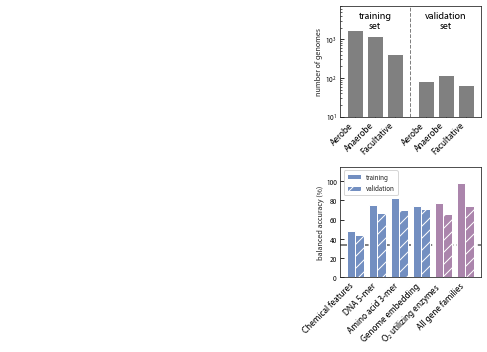

In [11]:
# Make figure 1
fig, axs = plt.subplots(figsize=(6.875, 5), nrows=2, ncols=2, 
                        gridspec_kw={"width_ratios": [2, 1]})

for ax in axs[:, 0]:
    ax.axis("off")

plt.sca(axs[0, 1])
label_order = "Aerobe,Anaerobe,Facultative".split(",")
training_labels = training_data["labels"]
training_counts = training_labels["physiology"].value_counts().loc[label_order]

validation_labels = validation_data["labels"]
validation_counts = validation_labels["physiology"].value_counts().loc[label_order]

plt.yscale("log")
xs1 = np.arange(training_counts.size)
plt.bar(xs1, training_counts.values, color="grey")
xs2 = np.arange(validation_counts.size) + xs1.size + 0.5
plt.bar(xs2, validation_counts.values, color="grey")

plt.axvline(xs1.size - 0.25, color="gray", lw=1, ls='--')
plt.ylabel("number of genomes")
plt.text(1, 3000, "training\nset", color="k", ha='center', va='center')
plt.text(4.5, 3000, "validation\nset", color="k", ha='center', va='center')

xs = np.concatenate([xs1, xs2])
xticks = np.concatenate([training_counts.index, validation_counts.index])
plt.xticks(xs, xticks, ha='right', rotation=45, fontsize=9)
plt.ylim(10, 7000)

plt.sca(axs[1, 1])

select_models = [
    'Chemical features',
    'Nucleotide kmer counts (5 mer)',
    'Amino acid counts (3 mer)',
    'genome embedding',
    'All O2 genes',
    'All KO families',
]

hue_order = 'training,validation'.split(',')
order = [feature_name_map[x] for x in select_models]
mask = model_results_long_df.feature_set.isin(select_models)

bar_heights_train = model_results_long_df[mask].query('eval_name == "training"')
bar_heights_train = bar_heights_train.set_index('feature_set').loc[select_models].balanced_accuracy_pct.values

bar_heights_valid = model_results_long_df[mask].query('eval_name == "validation"')
bar_heights_valid = bar_heights_valid.set_index('feature_set').loc[select_models].balanced_accuracy_pct.values

cmap = {'annot_free': colors['blue'], 'annot_full': colors['purple']}
model_type_order = 'annot_free,annot_free,annot_free,annot_free,annot_full,annot_full'.split(',')
color_order = [cmap[x] for x in model_type_order]
plt.bar(np.arange(len(order)), bar_heights_train, color=color_order, width=0.4, label='training')
plt.bar(np.arange(len(order))+0.4, bar_heights_valid, color=color_order, hatch='//', width=0.4, label='validation')
plt.xticks(np.arange(len(order))+0.2, order, rotation=45, ha='right', fontsize=9)

plt.axhline(33, ls='--', color='grey', zorder=-1)
plt.legend(title='', loc=2)
plt.ylabel('balanced accuracy (%)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 115)

plt.tight_layout()
plt.savefig("../../results/Fig1.png", dpi=300, facecolor="w")
plt.show()

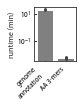

In [12]:
# make a little inset with runtime analysis
runtime_df = pd.read_csv('../../results/run_time_comparison.csv')
runtime_df['elapsed_time_min'] = runtime_df['elapsed_time']/60
runtime_df['label'] = runtime_df['feature_type'].map({'3mer': 'AA 3-mers', 'annotation': 'genome\nannotation'})
fig, ax = plt.subplots(figsize=(0.75, 1))

plt.yscale('log')
order = ['genome\nannotation', 'AA 3-mers']
sns.barplot(data=runtime_df, x='label', y='elapsed_time_min', color='grey', order=order)
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.ylabel('runtime (min)', fontsize=8)
plt.xlabel('')
plt.savefig('../../results/Fig1_inset.png', dpi=300, bbox_inches='tight')
plt.show()

Oxygen_label
Anaerobe       47
Aerobe         40
Facultative    12
Name: count, dtype: int64
['Aerobe', 'Anaerobe', 'Facultative']
[[23  5 12]
 [ 1 31 15]
 [ 0  1 11]]


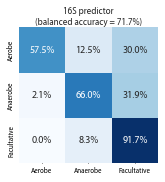

In [13]:
# Load the 16S prediction results
pred_16S = pd.read_csv('../../results/16S_predicted_labels.test_set.csv', index_col=0)
true_16S = pd.read_csv('../../results/16S_true_labels.test_set.csv', index_col=0)

print(true_16S['Oxygen_label'].value_counts())

classes = sorted(pred_16S['predicted_label'].unique())
print(classes)
C = confusion_matrix(true_16S['Oxygen_label'], pred_16S['predicted_label'], labels=classes)
print(C)
C = pd.DataFrame(C, index=classes, columns=classes)
C = C.apply(lambda x: x/x.sum(), axis=1)

bal_accuracy = balanced_accuracy_score(true_16S['Oxygen_label'], pred_16S['predicted_label'])

plt.figure(figsize=(2.5, 2.5))
sns.heatmap(C, cmap='Blues', annot=True, fmt='.1%', cbar=False)
plt.title('16S predictor\n(balanced accuracy = {0:.1f}%)'.format(bal_accuracy*100))
plt.savefig('../../results/FigS4.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [14]:
# Load the Earth microbiome project analysis and metadata
EMP_raw_df = pd.read_csv('../../results/EMP_merged_raw.csv')
EMP_filtered_df = pd.read_csv('../../results/EMP_merged_filtered.csv')
EMP_filtered_df.head()

,label,metagenome_id,genome_length,num_contigs,n50,num_16s,num_5s,num_23s,num_trna,completeness,...,quality_score,mimag_quality,otu_id,ecosystem,ecosystem_category,ecosystem_type,habitat,longitude,latitude,habitat_processed
0,Anaerobe,2049941000,3316074,15,321825,0.0,1.0,1.0,35.0,54.78,...,51.23,MQ,OTU-4238,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__S...,Mammals,Digestive system,Bovine rumen,-88.2315,40.096,Rumen
1,Anaerobe,2049941000,3100772,8,1604841,0.0,1.0,0.0,38.0,82.10,...,73.60,MQ,OTU-15006,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Mammals,Digestive system,Bovine rumen,-88.2315,40.096,Rumen
2,Anaerobe,2049941000,2989491,12,372983,0.0,1.0,0.0,37.0,76.67,...,65.52,MQ,OTU-10658,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Mammals,Digestive system,Bovine rumen,-88.2315,40.096,Rumen
3,Anaerobe,2049941000,2805320,13,370333,1.0,1.0,0.0,36.0,71.55,...,57.20,MQ,OTU-9196,d__Bacteria;p__UBA3054;c__UBA3054;o__UBA3054;f...,Mammals,Digestive system,Bovine rumen,-88.2315,40.096,Rumen
4,Anaerobe,2049941000,2711307,24,184630,0.0,0.0,0.0,20.0,70.64,...,65.44,MQ,OTU-7758,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,Mammals,Digestive system,Bovine rumen,-88.2315,40.096,Rumen


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_34982/252985770.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=habitat_counts[:10], x=habitat_counts[:10].index.values,
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_34982/252985770.py:22: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(y=habitat_counts[:10], x=habitat_counts[:10].index.values,


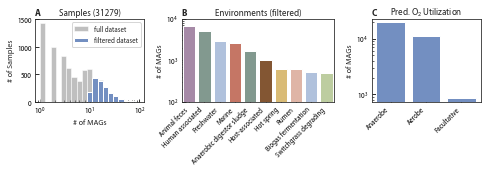

In [15]:
# Properties of the EMP dataset
fig, axs = plt.subplots(figsize=(6.875, 2.5), ncols=3, 
                        gridspec_kw={'width_ratios': [1, 1.4, 1]})
plt.sca(axs[0])
bins = np.logspace(0, 2, 20)
plt.xscale('log')

plt.hist(EMP_raw_df.metagenome_id.value_counts(), bins=bins,
         color='grey', alpha=0.5, label='full dataset')
plt.hist(EMP_filtered_df.metagenome_id.value_counts(), bins=bins,
         color=colors["blue"], label='filtered dataset')

plt.legend(loc=1)
plt.xlabel('# of MAGs')
plt.ylabel('# of Samples')
plt.title('Samples ({0})'.format(EMP_filtered_df.index.nunique()))

plt.sca(axs[1])
plt.yscale('log')
# Count up all the labels of MAGS from EMP by habitat
habitat_counts = EMP_filtered_df.habitat_processed.value_counts().sort_values(ascending=False)
sns.barplot(y=habitat_counts[:10], x=habitat_counts[:10].index.values,
            palette=default_pal)
plt.xticks(rotation=45, ha='right')
plt.yticks([1e2, 1e3, 1e4])
plt.ylabel('# of MAGs')
plt.title('Environments (filtered)')

plt.sca(axs[2])
plt.yscale('log')
# Count up all the labels of MAGS from EMP
label_counts = EMP_filtered_df.label.value_counts()

plt.bar(np.arange(3), label_counts.values, color=colors["blue"])
plt.xticks(np.arange(3), label_counts.index.values, rotation=45, ha='right')
plt.title('Pred. O$_2$ Utilization')
plt.ylabel('# of MAGs')

# Label panels
for ax, ax_label in zip(axs, 'ABC'):
    plt.sca(ax)
    plt.title(ax_label, loc='left', fontweight='bold')
    
plt.tight_layout()
plt.savefig('../../results/FigS5.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

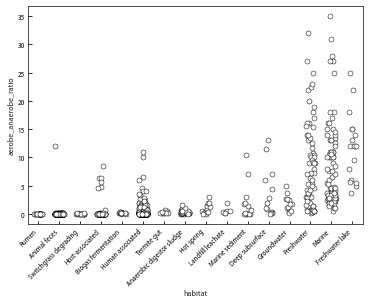

In [16]:
# Load the mean aerobe/anaerobe predictions for each habitat
mean_EMP_pcts_df = pd.read_csv('../../results/EMP_merged_filtered_mean_fracs_by_habitat.csv', index_col=0)

EMP_fracs_df = pd.read_csv('../../results/EMP_merged_filtered_fracs_by_sample.csv', index_col=0)

EMP_fracs_df.head()
mask = mean_EMP_pcts_df.total > 250
sorted_habitats = mean_EMP_pcts_df[mask].sort_values('f_Aerobe', ascending=True).index.values
mask2 = EMP_fracs_df.habitat.isin(sorted_habitats)

# Ideally I'd like to plot fold differences in aerobe/anaerobe ratios on a log scale
# however there are many samples where the ratio is 0 or infinity, so I can't do that.
plt.figure()
#plt.yscale('log')
sns.stripplot(data=EMP_fracs_df[mask2], x='habitat', y='aerobe_anaerobe_ratio',
              jitter=0.2, order=sorted_habitats, color='white', edgecolor='k', linewidth=0.5)

plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
# Load the black sea metadata
black_sea_metadata = pd.read_csv('../../results/black-sea/meta_data.csv', index_col=0)
black_sea_metadata['depth_m'] = black_sea_metadata['Depth'].str.strip('m').astype(float)

# Chemical measurements are from Sollai et al. 2019 Geobiology. In their figure 1
# it's clear these are in uM units despite what it says in our metadata file, which
# was downloaded from the SRA at this link:
# https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=3&WebEnv=MCID_6582027b68a595196d9af8e7&o=acc_s%3Aa
# uM units make sense as the Henry's law equilibrium of O2 in seawater is ~200 uM.
black_sea_metadata['o2_uM'] = black_sea_metadata.diss_oxygen.str.strip('mmol / kg').astype(float)
black_sea_metadata['h2s_uM'] = black_sea_metadata['hydrogen_sulfide'].str.strip('mM').astype(float)
black_sea_metadata.sort_values('depth_m', inplace=True)

In [18]:
# Load the black sea MAG inference results
black_sea_aerotypes = pd.read_csv('../../results/black-sea/black_sea_aerotypes.aa3merModel.csv', index_col=0)
black_sea_MAG_fractions = pd.read_csv('../../results/black-sea/blackSea.MAGfraction.04Feb2023.csv', index_col=0).drop('*')

black_sea_MAG_fractions['aerotype'] = black_sea_aerotypes.loc[black_sea_MAG_fractions.index]
O2_utilzation_fracs = black_sea_MAG_fractions.groupby('aerotype').sum().T
O2_utilization_pcts = O2_utilzation_fracs*100

# Check the totals
totals = O2_utilization_pcts.sum(axis=1)
assert (totals - 100).abs().max() < 1e-6

O2_utilization_pcts['depth_m'] = black_sea_metadata.loc[O2_utilization_pcts.index].depth_m
O2_utilization_pcts.sort_values('depth_m', inplace=True)
O2_utilization_pcts.head()

aerotype,Aerobe,Anaerobe,Facultative,depth_m
SRR12347146,91.576737,1.418828,7.004435,50.0
SRR12347145,94.658995,4.980436,0.360570,70.0
SRR12347139,95.031219,4.731364,0.237417,80.0
SRR12347138,91.762149,7.937447,0.300404,85.0
SRR12347137,89.494802,10.136071,0.369127,90.0


In [19]:
# Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
ox_sulfide_ratio = black_sea_metadata.o2_uM/black_sea_metadata.h2s_uM
aerobe_anaerobe_ratio = O2_utilization_pcts.Aerobe/O2_utilization_pcts.Anaerobe

# linear regression of the log-log data
log_ox_sulfide_ratio = np.log10(ox_sulfide_ratio)
log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)

reg_res = linregress(log_aerobe_anaerobe_ratio, log_ox_sulfide_ratio)
print(reg_res)
xs = np.logspace(-0.8, 2.1, 100)
pred_ys = reg_res.intercept + reg_res.slope*np.log10(xs)

LinregressResult(slope=2.3302367776414075, intercept=-1.6431460955366983, rvalue=0.9418088107235977, pvalue=1.599384514180643e-07, stderr=0.2306733790166578, intercept_stderr=0.18563170021693645)


habitat
Rumen                         606.0
Animal feces                 6639.0
Switchgrass degrading         494.0
Biogas fermentation           506.0
Termite gut                   319.0
Sediment                      245.0
Anaerobic digestor sludge    1656.0
Human associated             4983.0
Hot spring                    614.0
Landfill leachate             269.0
Marine sediment               320.0
Hot spring sediment           243.0
Deep subsurface               357.0
Groundwater                   419.0
Freshwater                   2814.0
Marine                       2633.0
Freshwater lake               416.0
Salt marsh                    247.0
Name: total, dtype: float64


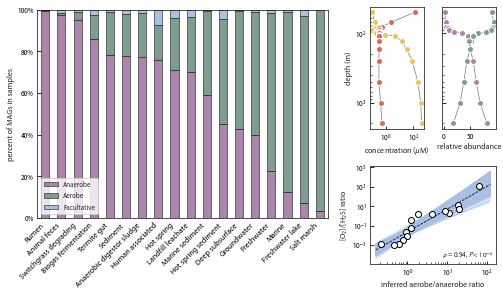

In [20]:
fig = plt.figure(figsize=(6.875, 4), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.02,
                         width_ratios=[2,1])

leftAx = subfigs[0].subplots(nrows=1, ncols=1)
rightAxs = subfigs[1].subplots(nrows=2, ncols=2, sharey='row',
                               gridspec_kw={'height_ratios': [1.25, 1]})

plt.sca(leftAx)
cols = 'habitat,pct_Anaerobe,pct_Aerobe,pct_Facultative'.split(',')
tmp = mean_EMP_pcts_df.reset_index()
mask = np.logical_and(tmp.total > 240,
                      np.logical_not(tmp.habitat.isin(['Host-associated'])))

sorted = tmp[cols][mask].set_index('habitat').sort_values('pct_Anaerobe', ascending=False)
sorted.plot(kind='bar', stacked=True, color=default_pal[:3], ax=leftAx, legend=False,
            edgecolor='k', linewidth=0.5)

# Printing the total number of MAGs per sample to verify it exceeds 250
totals = mean_EMP_pcts_df.loc[sorted.index].total
print(totals)

plt.legend('Anaerobe,Aerobe,Facultative'.split(','), loc=3)
plt.ylabel('percent of MAGs in samples')
plt.xlabel('')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylim(0, 100.1)
leftAx.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.sca(rightAxs[0, 0])
# Invert only the first -- also inverts the second since they share a y-axis.
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yscale('log')
plt.plot(black_sea_metadata.h2s_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=colors['yellow'], markeredgecolor='w', label='H$_2$S')
plt.plot(black_sea_metadata.o2_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=colors['red'], markeredgecolor='w', label='O$_2$')
plt.xlabel('concentration ($\mu$M)')
plt.ylabel('depth (m)')

plt.sca(rightAxs[0, 1])
plt.yscale('log')
for i, col in enumerate('Anaerobe,Aerobe'.split(',')):
    plt.plot(O2_utilization_pcts[col], O2_utilization_pcts.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=default_pal[i], markeredgecolor='w', label=col)
#plt.ylabel('Depth (m)')
plt.xlabel('relative abundance')

# Make a big axis to hold the correlation plot
gs = rightAxs[1, 0].get_gridspec()
# remove the underlying axes
for ax in rightAxs[1, :]:
    ax.remove()    
axbig = subfigs[1].add_subplot(gs[1, :])

plt.sca(axbig)
plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# bootstrap a confidence interval plot manually because
# seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg_res.slope, reg_res.stderr)
    intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
    pred_ys = intercept + slope*np.log10(xs)
    plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
             zorder=-10)

plt.xlabel('inferred aerobe/anaerobe ratio')
plt.ylabel('[O$_2$]/[H$_2$S] ratio')
plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
         fontsize=7, transform=plt.gca().transAxes, ha='right', va='bottom')


plt.savefig('../../results/Fig2.png', dpi=300, facecolor='w')

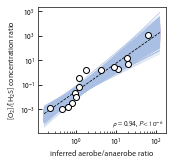

In [21]:
fig, axs = plt.subplots(ncols=1, figsize=(2.5, 2.4))

plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# bootstrap a confidence interval plot manually because
# seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg_res.slope, reg_res.stderr)
    intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
    pred_ys = intercept + slope*np.log10(xs)
    plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
             zorder=-10)

plt.xlabel('inferred aerobe/anaerobe ratio')
plt.ylabel('[O$_2$]/[H$_2$S] concentration ratio')
plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
         fontsize=7, transform=plt.gca().transAxes, ha='right', va='bottom')

plt.tight_layout()
plt.savefig('../../results/FigS6.png', facecolor='white', dpi=300)
plt.show()

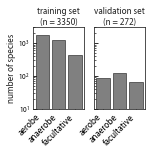

In [22]:
# Make a presentation summary of train and test sets
fig, axs = plt.subplots(figsize=(2,1.5), sharey=True, ncols=2)
cmap = {'aerobe': colors['blue'],
        'anaerobe': colors['red'],
        'facultative': colors['green']}

plt.sca(axs[0])
label_order = "Aerobe,Anaerobe,Facultative".split(",")
training_labels = training_data["labels"]
training_counts = training_labels["physiology"].value_counts().loc[label_order]
plt.yscale("log")
xs = np.arange(training_counts.size)
xticks = training_counts.index.str.lower()
#my_colors = [cmap[x] for x in xticks]
plt.bar(xs, training_counts.values, color='grey', edgecolor='k', linewidth=0.5)
plt.ylabel("number of species", fontsize=9)
plt.xticks(xs, xticks, ha='right', rotation=45, fontsize=9)
plt.title('training set\n(n = {0})'.format(training_counts.sum()), fontsize=9)
plt.ylim(10, 3000)

plt.sca(axs[1])
validation_labels = validation_data["labels"]
validation_counts = validation_labels["physiology"].value_counts().loc[label_order]

xs = np.arange(validation_counts.size)
xticks = validation_counts.index.str.lower()
#my_colors = [cmap[x] for x in xticks]
plt.bar(xs, validation_counts.values, color='grey', edgecolor='k', linewidth=0.5)
plt.xticks(xs, xticks, ha='right', rotation=45, fontsize=9)
plt.title('validation set\n(n = {0})'.format(validation_counts.sum()), fontsize=9)
plt.ylim(10, 3000)

plt.savefig('../../results/training_validation_presentation.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

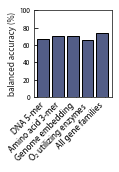

In [23]:
plt.figure(figsize=(1.4,1.6))

select_models = [
    'Nucleotide kmer counts (5 mer)',
    'Amino acid counts (3 mer)',
    'genome embedding',
    'All O2 genes',
    'All KO families',
]

model_type_order = [
    'annot_free',
    'annot_free',
    'annot_free',
    'annot_full',
    'annot_full',
]

hue_order = 'training,validation'.split(',')
order = [feature_name_map[x] for x in select_models]
mask = model_results_long_df.feature_set.isin(select_models)

bar_heights_train = model_results_long_df[mask].query('eval_name == "training"')
bar_heights_train = bar_heights_train.set_index('feature_set').loc[select_models].balanced_accuracy_pct.values

bar_heights_valid = model_results_long_df[mask].query('eval_name == "validation"')
bar_heights_valid = bar_heights_valid.set_index('feature_set').loc[select_models].balanced_accuracy_pct.values

cmap = {'annot_free': colors['blue'], 'annot_full': colors['purple']}
color_order = [cmap[x] for x in model_type_order]
#plt.bar(np.arange(len(order)), bar_heights_train, color=color_order, width=0.4, label='training',
#        edgecolor='k', linewidth=0.5)
#plt.bar(np.arange(len(order))+0.4, bar_heights_valid, color=color_order, hatch='//', width=0.4, label='validation',
#        edgecolor='k', linewidth=0.5)
#plt.xticks(np.arange(len(order))+0.2, order, rotation=45, ha='right', fontsize=9)

plt.bar(np.arange(len(order)), bar_heights_valid, color=colors['dark_blue'], 
        label='validation', edgecolor='k', linewidth=1)
plt.xticks(np.arange(len(order))+0.2, order, rotation=45, ha='right', fontsize=9)

#plt.axhline(33, ls='--', color='grey', zorder=-1)
#plt.axhline(66, ls='--', color='grey', zorder=-1)

plt.legend(title='', loc=2).set_visible(False)
plt.ylabel('balanced accuracy (%)', fontsize=9)
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

plt.savefig('../../results/model_results_presentation.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()


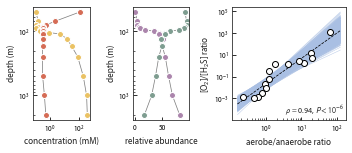

In [24]:
# presentation version of the black sea figure
fig, axs = plt.subplots(ncols=3, figsize=(5, 2.25), sharey=False, 
                        gridspec_kw={'width_ratios': [1, 1, 2]})

plt.sca(axs[0])
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yscale('log')
plt.plot(black_sea_metadata.h2s_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=colors['yellow'], markeredgecolor='w', label='H$_2$S')
plt.plot(black_sea_metadata.o2_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
            color='grey', markerfacecolor=colors['red'], markeredgecolor='w', label='O$_2$')
plt.xlabel('concentration (mM)', fontsize=9)
plt.ylabel('depth (m)', fontsize=9)
#plt.legend()

plt.sca(axs[1])
plt.gca().invert_yaxis()
plt.yscale('log')
for i, col in enumerate('Anaerobe,Aerobe'.split(',')):
    plt.plot(O2_utilization_pcts[col], O2_utilization_pcts.depth_m, marker='o', ls='-', lw=0.75,
         color='grey', markerfacecolor=default_pal[i], markeredgecolor='w', label=col)
plt.ylabel('depth (m)', fontsize=9)
plt.xlabel('relative abundance', fontsize=9)
#plt.legend()

# put fig s6 here -- the one with the concentrations vs aerobe/anaerobe ratio
plt.sca(axs[2])
plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

xs = np.logspace(-0.8, 2.1, 100)
pred_ys = reg_res.intercept + reg_res.slope*np.log10(xs)
plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# bootstrap a confidence interval plot manually because
# seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg_res.slope, reg_res.stderr)
    intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
    pred_ys = intercept + slope*np.log10(xs)
    plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
             zorder=-10)

plt.xlabel('aerobe/anaerobe ratio', fontsize=9)
plt.ylabel('[O$_2$]/[H$_2$S] ratio', fontsize=9)
plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
         fontsize=8, transform=plt.gca().transAxes, ha='right', va='bottom')

# Manually align the xtick labels
for my_ax in axs:
    my_ax.xaxis.set_label_coords(0.5, -0.15)

plt.tight_layout()
plt.savefig('../../results/black_sea_presentation.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
# calculate the fold error if we predict O2/H2S from the aerobe/anaerobe ratio
pred_ys = reg_res.intercept + reg_res.slope*np.log10(aerobe_anaerobe_ratio)
residuals = log_ox_sulfide_ratio - pred_ys

# regression was done on log10 scale, so residuals are log10(fold error)
fold_errors = 10**residuals
print(fold_errors.mean())


2.6404973916931684


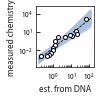

In [26]:
# just the correlation figure
fig, ax = plt.subplots(ncols=1, figsize=(1.5, 1.5), sharey=False)

plt.sca(ax)
plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio,
           marker='o', ls='', color='grey',
           markerfacecolor='w', markeredgecolor='k', 
           markersize=4)

xs = np.logspace(-0.8, 2.1, 100)
pred_ys = reg_res.intercept + reg_res.slope*np.log10(xs)
plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# bootstrap a confidence interval plot manually because
# seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg_res.slope, reg_res.stderr)
    intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
    pred_ys = intercept + slope*np.log10(xs)
    plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
             zorder=-10)

plt.xlabel('est. from DNA', fontsize=9)
plt.ylabel('measured chemistry', fontsize=9)
#plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
#         fontsize=8, transform=plt.gca().transAxes, ha='right', va='bottom')

plt.tight_layout()
plt.savefig('../../results/black_sea_sensing.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
EMP_res_df = pd.read_csv('../../results/aa3mer.aerotype.EarthMicrobiome.csv', index_col=0)


In [28]:
EMP_res_df.index.unique().size

52515